In [1]:
import jax
import jax.numpy as jnp
from jax import random

import numpy as np

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, log_likelihood

import matplotlib.pyplot as plt

from model import *

plt.rcParams['font.size'] = 14
# plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['axes.grid']=False
plt.rcParams['grid.linestyle']='--'
plt.rcParams['grid.linewidth'] = 1.0
plt.rcParams['axes.axisbelow'] = True

/Users/murakami/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


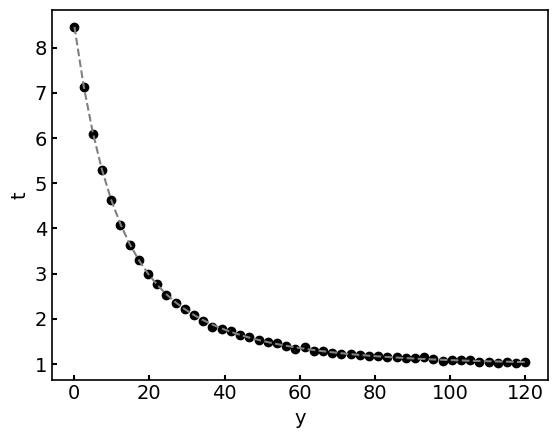

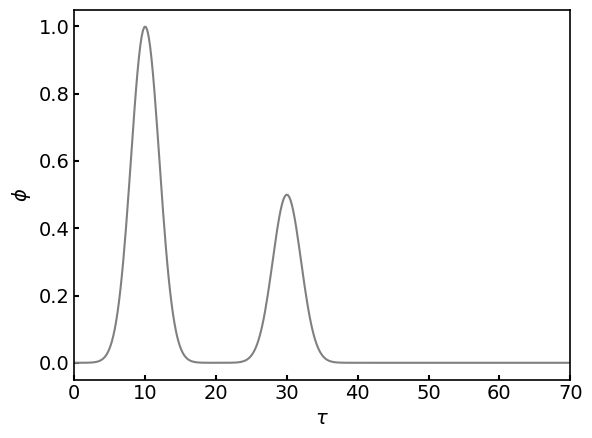

In [50]:

# 離散化されたτ空間（例: 対数スケールで10^-1 ～ 10^2）
N = 500
# tau = jnp.linspace(0.1, 100.0, N)  # τ: (N,)
tau = jnp.linspace(0.1, 100.0, N)  # τ: (N,)

# 入力時間軸
M = 50
t = jnp.linspace(0.1, 120.0, M)  # t: (M,)

b=1
h_true=jnp.array([1.0, 0.5])
mu_true=jnp.array([10.0, 30.0])
sigma_true=jnp.array([2.0, 2.0])
phi_true = calc_phi_K(tau, h_true, mu_true, sigma_true)
y_true = calc_f_K(t, tau, b, h_true, mu_true, sigma_true)

key = random.PRNGKey(0)
noise = 0.02 * random.normal(key, shape=y_true.shape)
y_obs = y_true + noise

plt.plot(t, y_true, ls='--', color='gray')
plt.scatter(t, y_obs, color='k')
plt.xlabel(r'y')
plt.ylabel(r't')
plt.show()

plt.plot(tau, phi_true, c='gray')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\phi$')
plt.xlim(0, 70)
plt.show()

In [51]:
num_samples = num_warmup = 2000
num_chains = 5
K = 2

kernel = NUTS(model, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=num_chains)
mcmc.run(random.PRNGKey(1), t=t, y_obs=y_obs, tau=tau, K=K)
mcmc.print_summary()

/var/folders/h6/361ss89923jd1mqx4n307p4w0000gn/T/ipykernel_31211/3953379714.py:6: UserWarning: There are not enough devices to run parallel chains: expected 5 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(5)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=num_chains)
sample: 100%|██████████| 4000/4000 [00:21<00:00, 189.03it/s, 3 steps of size 2.33e-03. acc. prob=0.96]   


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      0.96      0.05      0.98      0.90      1.02    138.40      1.03
      h[0]      0.94      0.31      0.92      0.55      1.47    229.11      1.03
      h[1]      0.91      0.29      0.86      0.55      1.43    347.83      1.03
     mu[0]     27.67     16.30     30.25      9.13     46.23      3.54      1.89
     mu[1]     22.79     17.29     12.13      8.98     43.01      3.61      1.97
  sigma[0]      1.72      1.34      1.19      0.27      3.83      4.56      1.53
  sigma[1]      2.09      1.31      1.84      0.28      4.01      4.49      1.53
   sigma_y      0.02      0.00      0.02      0.01      0.02   3156.29      1.00

Number of divergences: 0


Text(0, 0.5, 'y')

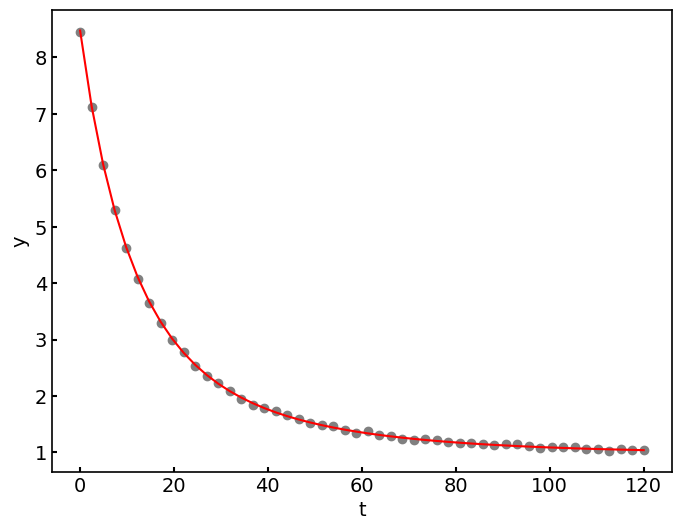

In [52]:
plt.figure(figsize=(8, 6))
plt.scatter(t, y_obs, c='gray')
plt.plot(t, mcmc.get_samples()['f'][-1, :], color='r')
plt.xlabel('t');plt.ylabel('y')

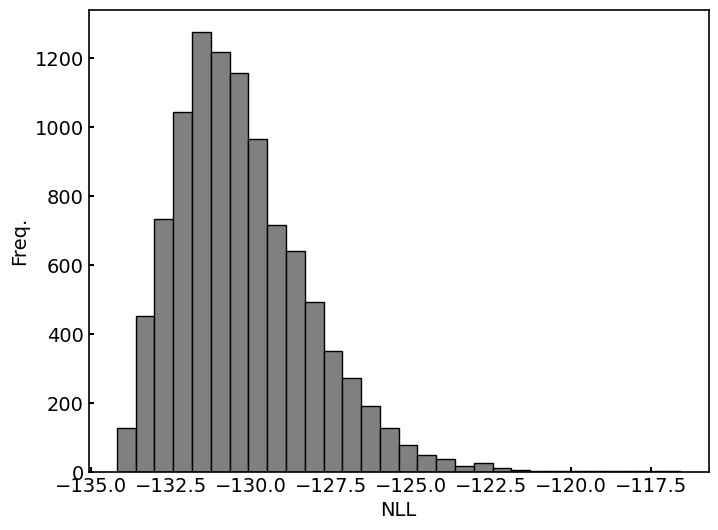

In [53]:
log_likelihood_dict = log_likelihood(
    model=model, posterior_samples=mcmc.get_samples(), 
    t=t, y_obs=y_obs, tau=tau, K=K)
nll = -1.0 * jnp.sum( log_likelihood_dict['obs'], axis=1)
plt.figure(figsize=(8, 6))
plt.hist(nll, bins=30, color='gray', edgecolor='k')
plt.xlabel('NLL'); plt.ylabel('Freq.')
plt.show()

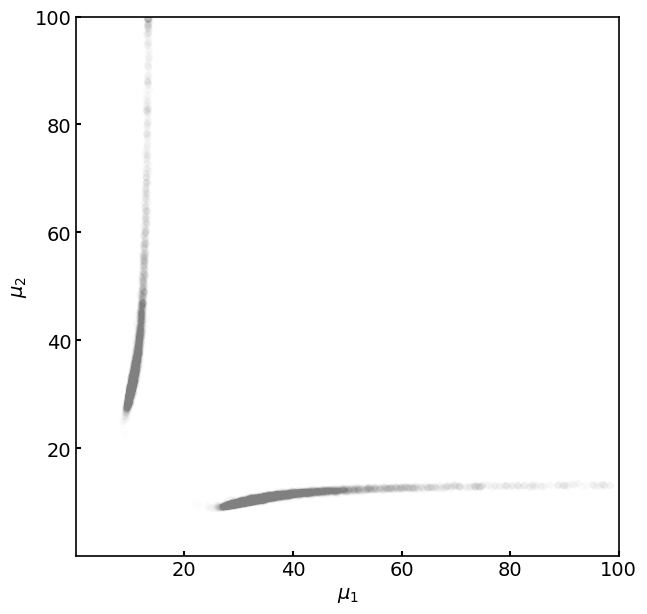

In [54]:
plt.figure(figsize=(7, 7))
plt.scatter(mcmc.get_samples()['mu'][:, 0], mcmc.get_samples()['mu'][:, 1], 
                    alpha=0.01, c='gray', s=20)
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')
plt.xlim(tau.min(), tau.max())
plt.ylim(tau.min(), tau.max())
plt.show()

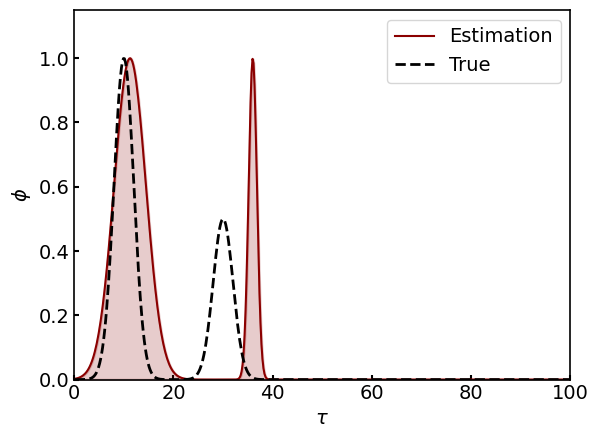

In [55]:
argmin_nll = np.argmin(nll)

tcd = np.zeros( len(tau) )
for k in range(K):
    est_sigma = np.mean( mcmc.get_samples()['sigma'][argmin_nll, k] )
    est_mean = np.mean( mcmc.get_samples()['mu'][argmin_nll, k] )
    tcd += gaussian(tau, est_mean, est_sigma)
    
plt.plot(tau, tcd, color='darkred', label='Estimation')
plt.fill_between(tau, tcd, color='darkred', alpha=0.2, lw=2)
    
plt.plot(tau, phi_true, c='k', ls='--', label='True', lw=2)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\phi$')

plt.legend()
plt.xlim(0, 100)
plt.ylim(0, 1.15)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\phi$')
plt.show()